# Исследование интернет-магазина игр

# 0. Введение

Цель анализа выявить факторы влияющие на успешность компьютерных игр. 
Это поможет правильно распределить рекламный бюджет.

Разобьем работу на несколько этапов:
- Подготовка данных
- Исследовательский анализ
- Составление портрета пользователя каждого региона
- Проверка статистических гипотезы

# 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)

In [2]:
df=pd.read_csv('/datasets/games.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
df.to_csv('games.csv')

In [215]:
df.duplicated().count()

16715

In [216]:
df

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Таблица содержит 11 столбцов с разными типами данных. Полных дубликатов нет. 
Пропуски в столбце Year_of_Release заменим медианами для каждой платформы и приведем к типу int.
Пропуски в столбцах Critic_Score, User_Score оставим, дабы не нарушать распределение.
Абревиаутра tbd в столбцее User_Score означает, что значение еще не установленно и будет заполнено позже. Заменим их медианными значениями для каждого жанра.

# 2. Подготовим данные

Заменим названия столбцов, приведя их к нижнему регистру

In [217]:
coll=list(df.columns)
cols=list(df.columns.str.lower())
dic=dict(zip(coll,cols))
df=df.rename(columns=dic)

Преобразуем столбец year_of_release к типу float

Заменим пропуски в столбце Year_of_Release медианами для каждой платформы

In [218]:
df.loc[df['year_of_release'].isna(), 'year_of_release'] = df.groupby('platform')['year_of_release'].transform('median')

Преобразуем столбец year_of_release к типу int

In [219]:
df.year_of_release=df.year_of_release.astype('int')

Взглянем на пропуски в названиях игр

In [220]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Они согласуются с пропусками в жанрах и рейтингах. Удалим неинформативные строки

In [221]:
df=df.drop(df[df['name'].isna()].index)

Заменим аббревиатуру 'tbd' в столбце user_score медианными значениями для каждого жанра.
Сменим тип на float.

In [222]:
df['us']=pd.to_numeric(df['user_score'], errors='coerce') #в допольнительный столбец перенесем числовые значения
df.loc[df['user_score']=='tbd', 'user_score']=df.groupby('genre')['us'].transform('median') #по ним рассчитаем медтаны
del df['us']
df['user_score']=df['user_score'].astype('float')

Посмотрим на результаты проделанных операций

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null float64
rating             9949 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 2.2+ MB


Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец all_sales

In [224]:
df['all_sales']=df.eu_sales+df.na_sales+df.jp_sales+df.other_sales
new_order = [0,1,2,3, 4, 5,6,7,11,8,9, 10]
df = df[df.columns[new_order]]
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,all_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN


# 3. Проведем исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы

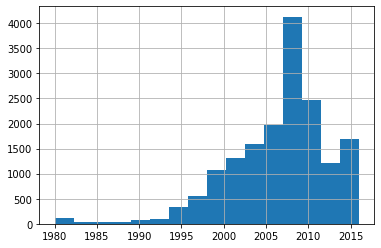

In [225]:
df['year_of_release'].hist(bins=16)

Оставим игры не старше 1994 года. Так как до этого выпускалолсь сравнительно мало игр.

In [226]:
df_plat=df.query('year_of_release>1994')

Посмотрим, как менялись продажи по платформам.
Для этого выберем 10 платформ с наибольшими суммарными продажами

In [227]:
plat_list=df.groupby('platform')['all_sales'].sum().sort_values(ascending=False).head(10).index.to_list()
plat_list

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC']

Построим на распределение продаж по годам

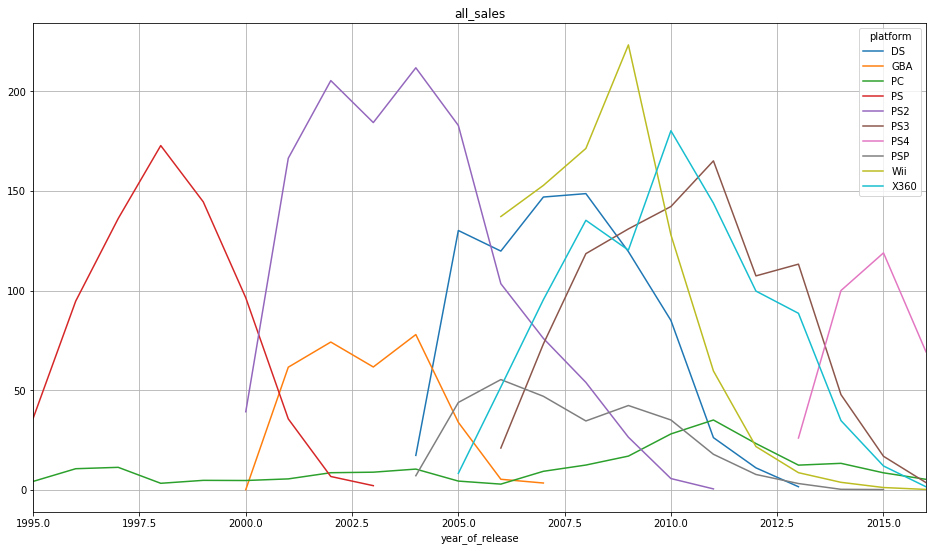

In [228]:
df_plat_plot=(
    df_plat[df_plat['platform'].isin(plat_list)]
    .pivot_table(index='platform', columns='year_of_release', values='all_sales', aggfunc='sum')
    .transpose()
    .plot(kind='line', figsize=(16,9), grid = True, title='all_sales')
)

Из графика видно, что в среднем срок жизни платформы составляет примерно 7 лет.
Ограничимся периодом 2009 по 2016 год

In [229]:
df=df.query('year_of_release>2008')

Все платформы к 2016 сильно снизились в продажах. Вероятно в следующем периоде будет актуальна PS5 и возможно PC.

Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам

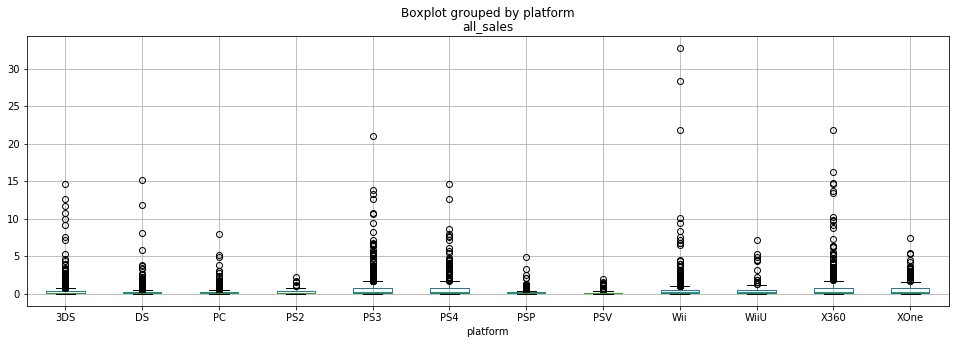

In [230]:
df.boxplot(column='all_sales', by='platform',figsize=(16,5))

Многие платформы имеют выбросы и сильно отличаются в продажах.
Взлянем на медианые значения в интервале от 0 до 5

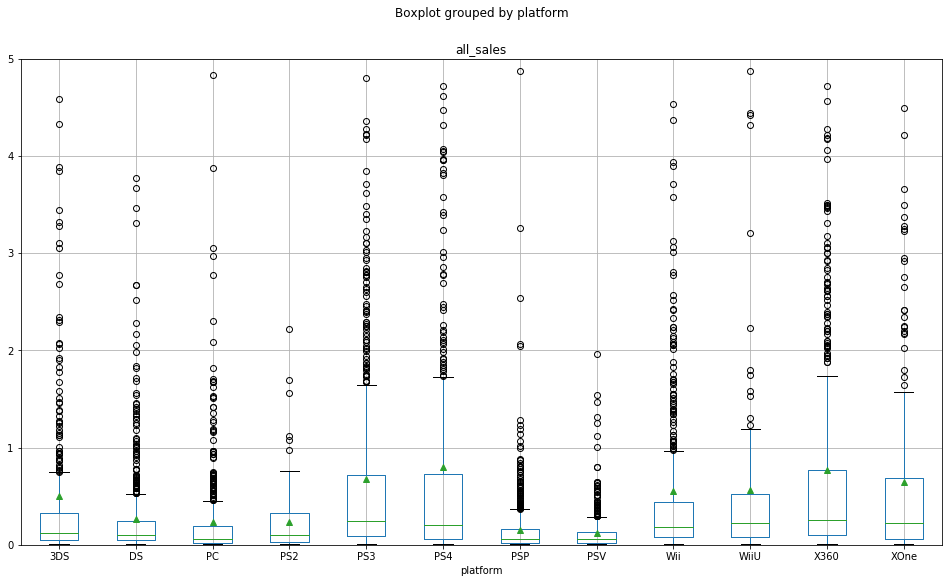

In [231]:
axes = df.boxplot(column='all_sales', by='platform',figsize=(16,9), return_type='axes', showmeans=True)
plt.ylim(0, 5)
plt.show()

Медианные значения отличаются не сильно и укладываются в диапазон 0-0,5.
Средние значения различаются чуть сильнее за счет больших выбросов.

### Посмотрим, как влияют на продажи внутри популярной платформы PS3 отзывы пользователей и критиков 

Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [232]:
df_ps2=df.query('platform=="PS3"')

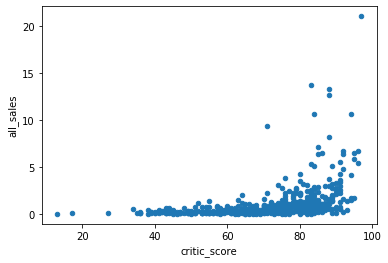

In [233]:
df_ps2.plot(x='critic_score', y='all_sales', kind='scatter')

In [234]:
df_ps2['critic_score'].corr(df_ps2['all_sales'])

0.4175605172015072

Зависимость от отзывов критиков небольшая

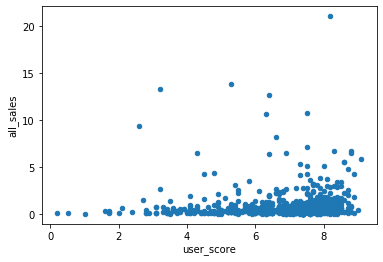

In [235]:
df_ps2.plot(x='user_score', y='all_sales', kind='scatter')

In [236]:
df_ps2['user_score'].corr(df_ps2['all_sales'])

0.07081753917551567

Зависимость от отзывов пользователей еще меньше

Посмотрим на корреляцию продаж с отзывавми на других платформах

In [237]:
for pl in plat_list:
    print(pl)
    df_pl=df.query('platform==@pl')
    a=round(df_pl['all_sales'].corr(df_pl['critic_score']), 3)
    b=round(df_pl['all_sales'].corr(df_pl['user_score']), 3)
    print( 'critic_score_corr', a , '; user_score_corr', b)

PS2
critic_score_corr 0.432 ; user_score_corr 0.089
X360
critic_score_corr 0.365 ; user_score_corr 0.061
PS3
critic_score_corr 0.418 ; user_score_corr 0.071
Wii
critic_score_corr 0.223 ; user_score_corr 0.068
DS
critic_score_corr 0.344 ; user_score_corr 0.118
PS
critic_score_corr nan ; user_score_corr nan
GBA
critic_score_corr nan ; user_score_corr nan
PS4
critic_score_corr 0.407 ; user_score_corr -0.037
PSP
critic_score_corr 0.389 ; user_score_corr 0.11
PC
critic_score_corr 0.295 ; user_score_corr -0.03


На других платформах схожие результаты. Зависиомть от отзывов низкая

Посмотрим на общее распределение игр по жанрам

In [238]:
df_genre=df.pivot_table(index='genre', values='all_sales', aggfunc=['count','sum'])
df_genre.columns=['count','sum']
df_genre.sort_values(by='sum', ascending=False)

,count,sum
genre,,
Action,1798,828.48
Shooter,515,554.91
Sports,777,471.91
Role-Playing,677,363.40
Misc,801,318.85
Platform,184,160.78
Racing,332,158.40
Fighting,255,113.75
Simulation,350,105.89


Самыми прибыльными жанрами являются Action, Sports и Shooter.
Самым низкоприбыльным жанром оказалась Strategy.

# 4. Составим портрет пользователя каждого региона

### Для пользователей из региона NA

Самые популярные платформы (топ-5)

In [239]:
df_na_pl=(
    df.pivot_table(index='platform', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False)
)
df_na_pl['na_%']=(df_na_pl['na_sales']*100/df_na_pl['na_sales'].sum()).round(1)
df_na_pl=df_na_pl.reset_index().head()

Самые популярные жанры (топ-5)

In [240]:
df_na_ge=(
    df.pivot_table(index='genre', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False)
)
df_na_ge['na_%']=(df_na_ge['na_sales']*100/df_na_ge['na_sales'].sum()).round(1)
df_na_ge=df_na_ge.reset_index().head()

Самые популярные рейтинги ESRB

In [241]:
df_na_rat=(
    df.pivot_table(index='rating', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False)
)
df_na_rat['na_%']=(df_na_rat['na_sales']*100/df_na_rat['na_sales'].sum()).round(1)
df_na_rat=df_na_rat.reset_index().head()

Объединим три таблицы в одну

In [242]:
df_na = pd.concat([ df_na_pl,df_na_ge, df_na_rat], axis=1)

### Для пользователей из региона EU

Самые популярные платформы (топ-5)

In [243]:
df_eu_pl=(
    df.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales', ascending=False)
)
df_eu_pl['eu_%']=(df_eu_pl['eu_sales']*100/df_eu_pl['eu_sales'].sum()).round(1)
df_eu_pl=df_eu_pl.reset_index().head()

Самые популярные жанры (топ-5). Поясните разницу.

In [244]:
df_eu_ge=(
    df.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales', ascending=False)
)
df_eu_ge['eu_%']=(df_eu_ge['eu_sales']*100/df_eu_ge['eu_sales'].sum()).round(1)
df_eu_ge=df_eu_ge.reset_index().head()

Самые популярные рейтинги ESRB

In [245]:
df_eu_rat=(
    df.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales', ascending=False)
)
df_eu_rat['eu_%']=(df_eu_rat['eu_sales']*100/df_eu_rat['eu_sales'].sum()).round(1)
df_eu_rat=df_eu_rat.reset_index().head()

Объединим три таблицы в одну

In [246]:
df_eu = pd.concat([ df_eu_pl, df_eu_ge, df_eu_rat], axis=1)

### Для пользователей из региона JP

Самые популярные платформы (топ-5)

In [247]:
df_jp_pl=(
    df.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales', ascending=False)
)
df_jp_pl['jp_%']=(df_jp_pl['jp_sales']*100/df_jp_pl['jp_sales'].sum()).round(1)
df_jp_pl=df_jp_pl.reset_index().head()

Самые популярные жанры (топ-5). Поясните разницу.

In [248]:
df_jp_ge=(
    df.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales', ascending=False)
)
df_jp_ge['jp_%']=(df_jp_ge['jp_sales']*100/df_jp_ge['jp_sales'].sum()).round(1)
df_jp_ge=df_jp_ge.reset_index().head()

Самые популярные рейтинги ESRB

In [249]:
df_jp_rat=(
    df.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales', ascending=False)
)
df_jp_rat['jp_%']=(df_jp_rat['jp_sales']*100/df_jp_rat['jp_sales'].sum()).round(1)
df_jp_rat=df_jp_rat.reset_index().head()

Объединим три таблицы в одну

In [250]:
df_jp = pd.concat([ df_jp_pl,df_jp_ge, df_jp_rat], axis=1, sort=False)

Взлянем на сводные таблицы для трех регионов

In [251]:
df_na

,platform,na_sales,na_%,genre,na_sales,na_%,rating,na_sales,na_%
0,X360,414.91,27.8,Action,370.50,24.9,M,444.17,34.2
1,PS3,295.26,19.8,Shooter,279.32,18.7,E,407.18,31.4
2,Wii,245.78,16.5,Sports,231.77,15.6,T,235.91,18.2
3,DS,120.61,8.1,Misc,169.74,11.4,E10+,209.83,16.2
4,PS4,108.74,7.3,Role-Playing,131.19,8.8,EC,1.32,0.1


In [252]:
df_eu

,platform,eu_sales,eu_%,genre,eu_sales,eu_%,rating,eu_sales,eu_%
0,PS3,258.08,24.8,Action,277.92,26.7,M,329.51,37.7
1,X360,199.16,19.1,Shooter,194.50,18.7,E,261.99,29.9
2,PS4,141.09,13.5,Sports,159.65,15.3,T,157.01,17.9
3,Wii,128.11,12.3,Misc,87.67,8.4,E10+,126.33,14.4
4,PC,84.39,8.1,Role-Playing,83.73,8.0,RP,0.08,0.0


In [253]:
df_jp

,platform,jp_sales,jp_%,genre,jp_sales,jp_%,rating,jp_sales,jp_%
0,3DS,100.67,27.2,Role-Playing,120.81,32.7,E,61.50,36.3
1,PS3,69.07,18.7,Action,85.05,23.0,T,50.76,30.0
2,DS,52.11,14.1,Misc,31.11,8.4,M,36.29,21.4
3,PSP,51.29,13.9,Sports,25.61,6.9,E10+,20.82,12.3
4,Wii,35.37,9.6,Platform,20.65,5.6,EC,0.00,0.0


В северной Америке и Европе распространены X360 PS2 Nintendo.
В Японии отдают предпочтение отчественным приставкам Nintendo и PlayStation.

В северной Америке и Европе больше любителей жанров Action, Sports и Shooter.
В Японии на перое место выходит жанр Role-Playing, а любителей Shooter немного.

Игры с ретингом Е (для всех) очевидно имеют наибольшее распространение и прибыль.

# 5. Проверим гипотезы

Будем сравнивать средние пользовательские рейтинги с помощью т-теста.
Уровень значимотсти установим 5%

In [254]:
alpha=0.05

Сформулируем нулевую гипотезу:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем альтернативную гипотезу:
- Средние пользовательские рейтинги платформ Xbox One и PC разные

In [255]:
results=st.ttest_ind(df.loc[df['platform']=='XOne','user_score'], df.loc[df['platform']=='PC','user_score'], nan_policy='omit', equal_var =True)

print('p-значение: ', results.pvalue  )

if (results.pvalue  < alpha):
    print("Средние пользовательские рейтинги платформ Xbox One и PC разные")
else:
    print("Средние пользовательские рейтинги платформ Xbox One и PC действительно одинаковые")


p-значение:  0.2186047140666257
Средние пользовательские рейтинги платформ Xbox One и PC действительно одинаковые


Сформулируем нулевую гипотезу:
- Средние пользовательские рейтинги жанров Action и Sports разные

Сформулируем альтернативную гипотезу:
- Средние пользовательские рейтинги жанров Action  и Sports одинаковые

In [256]:
results=st.ttest_ind(df.loc[df['genre']=='Action','user_score'], df.loc[df['genre']=='Sports','user_score'], nan_policy='omit', equal_var =True)

print('p-значение: ', results.pvalue  )

if (results.pvalue  < alpha):
    print("Средние пользовательские рейтинги жанров Action и Sports разные")
else:
    print("Средние пользовательские рейтинги жанров Action и Sports одинаковые")


p-значение:  1.5656111813651109e-09
Средние пользовательские рейтинги жанров Action и Sports разные


# 6. Общий вывод

В ходе исследования было выполнено:

- Заменены названия столбцов 
- Преобразованы данные в нужные типы
- Обработаны пропуски

- Посчитаны суммарные продажи во всех регионах 
- Изучено как менялись продажи по платформам по годам
- Изучено какие платформы лидируют по продажам, растут или падают 
- Построены графики «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам

- Изучено как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков
- Построены диаграмму рассеяния и посчитаны корреляции между отзывами и продажами
- Изучено общее распределение игр по жанрам
- Для пользователей каждого региона определны самые популярные платформы, жанры и рейтинги ESRB

- Подтверждена гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Подтверждена гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports разные